# Text Classification
In this project we will perform a text classification on the 20newsgroup text using both Naive Bayes and SVM. The package provided from the sklearn dataset provides a great introduction to text classification, and comes presplit, with little work required to get to point of analysis
    
The code, along with the files necessary and versions of packages in this instance can be found on this repo: https://github.com/Benjamin-Siebold/MSDS-682-Text-Analytics

In [307]:
import numpy as np
import pandas as pd
import time

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from wordcloud import WordCloud

from tqdm import tqdm
import nltk
import spacy
import re
from matplotlib import pyplot as plt

nlp = spacy.load('en_core_web_lg')

### 1 - Import and Prepare data
The first step in this analysis is to import the data in its train and test subgroups, remove excess information, and create our vectorizer and transforms for analysis

In [64]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [104]:
def clean_from_articles(newsgroups):
    clean = []
    for i, a in enumerate(newsgroups['data']):
        cln1 = re.sub('^#>.*\n', '', a, flags=re.MULTILINE)
        clean.append(re.sub('\n*.*From article.*\n', '', cln1))
    
    return clean

In [72]:
clean_train = clean_from_articles(newsgroups_train)

In [73]:
clean_test = clean_from_articles(newsgroups_test)

In [205]:
vectorizer = TfidfVectorizer()
train_labels = newsgroups_train['target']
train_feats = vectorizer.fit_transform(clean_train)
test_labels = newsgroups_test['target']
test_feats = vectorizer.transform(clean_test)

In [200]:
test_feats.todense().shape

(7532, 101631)

### 2 - Apply Models to text
The next step is to create both our NB and SVM models in order to find which classifier best suits this data. We can see from below using a MNB with no altercations only gives us a 60% accuracy score on our test data; however, by adjusting the alpha we are able to increase the models effeciency by 10%. In regards to the SVM model, following a linear model we achieve an accuracy score of 66, thus the NB model with an alpha of .01 is the best model of these tested

In [320]:
model = MultinomialNB()
model.fit(train_feats, train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [321]:
model.score(train_feats,train_labels)

0.8115608980024748

In [322]:
pred = model.predict(test_feats)
print(model.score(test_feats,test_labels))

0.6060807222517259


In [206]:
model = MultinomialNB(alpha=.01)
model.fit(train_feats, train_labels)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [207]:
model.score(train_feats,train_labels)

0.9588120912144246

In [208]:
pred = model.predict(test_feats)
print(model.score(test_feats,test_labels))

0.7000796601168349


In [188]:
accuracy_score(pred, test_labels)

0.7000796601168349

In [130]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=2, gamma='auto')

In [131]:
SVM.fit(train_feats, train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [132]:
start = time.time()
svm_predict = SVM.predict(test_feats)
end = time.time()
print('took', int(end-start), 'seconds')

took 76 seconds


In [133]:
print("SVM Accuracy Score -> ",accuracy_score(svm_predict, test_labels)*100)

SVM Accuracy Score ->  66.25066383430695


### 3 - Build visuals of results
The next step is to build a classification report, and some visuals of our results. The dataframe of our classification report shows each of the classes almost evenly distributed, and the heatmap gives a quick visual that the model was really accurate with baseball classification, and had trouble around religion (atheism, religion christiantiy, religion).

In [232]:
t1 = []
t2 = []
for idx, cat in enumerate(newsgroups_train.target_names):
    t1.append(idx)
    t2.append(cat)
d = {'targets':t1, 'target_names':t2}
target_names_map = pd.DataFrame(d)

In [294]:
class_report = classification_report(test_labels, pred, target_names=target_names_map['target_names'], output_dict=True)

In [304]:
pd.DataFrame(class_report).transpose()

,precision,recall,f1-score,support
alt.atheism,0.568548,0.442006,0.497354,319.00000
comp.graphics,0.650235,0.712082,0.679755,389.00000
comp.os.ms-windows.misc,0.716263,0.525381,0.606149,394.00000
comp.sys.ibm.pc.hardware,0.594883,0.711735,0.648084,392.00000
comp.sys.mac.hardware,0.724324,0.696104,0.709934,385.00000
comp.windows.x,0.815642,0.739241,0.775564,395.00000
misc.forsale,0.825959,0.717949,0.768176,390.00000
rec.autos,0.744845,0.729798,0.737245,396.00000
rec.motorcycles,0.766404,0.733668,0.749679,398.00000
rec.sport.baseball,0.933140,0.808564,0.866397,397.00000


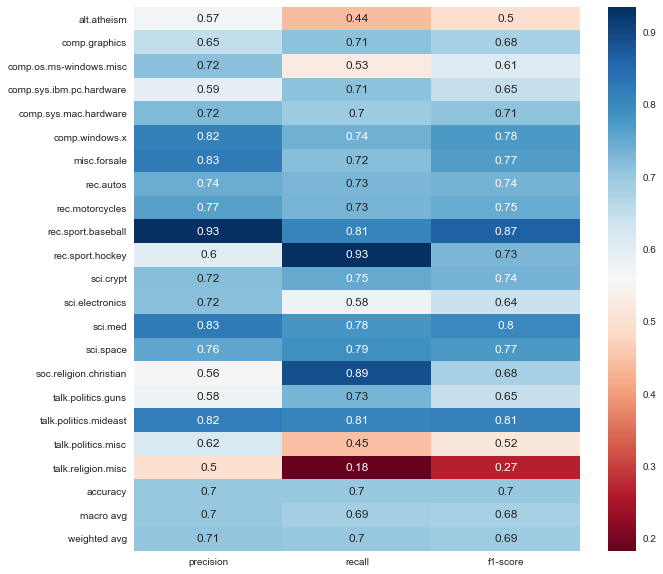

In [298]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True, ax=ax, cmap = 'RdBu')

### 4 - Visualize datasets
The last step in this analysis was a visualization of the two datasets (train and test) in order to see if it was possible to see overlap visually and easily.

In [318]:
clean_train_text = ' '.join(clean_train)
clean_test_text = ' '.join(clean_test)

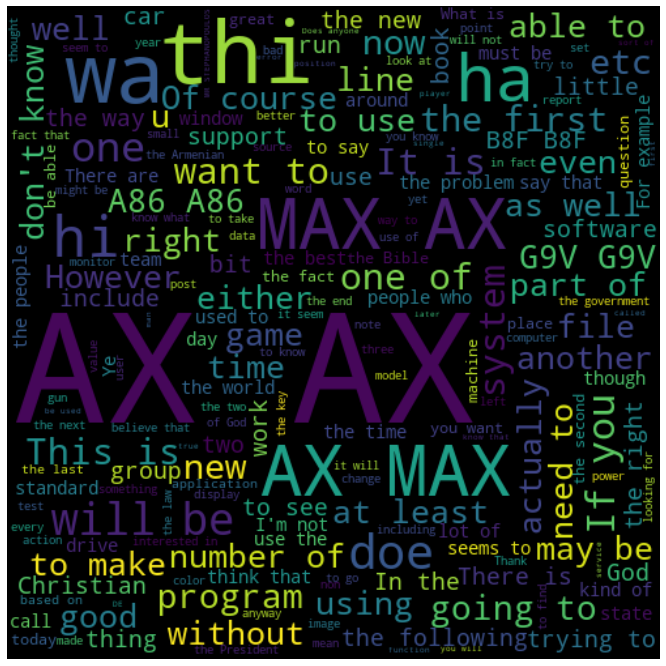

In [317]:
fig = plt.figure(figsize=(12, 12))
wordcloud = WordCloud(width=500, height=500).generate(clean_train_text)
plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

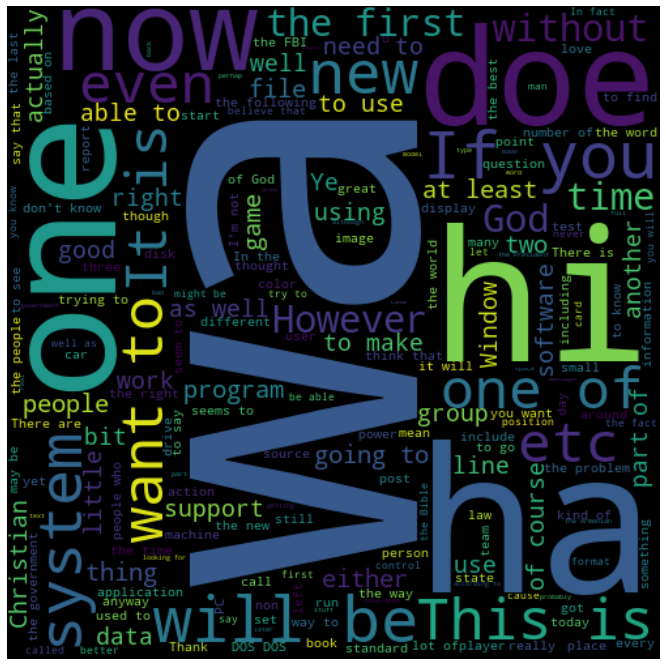

In [319]:
fig = plt.figure(figsize=(12, 12))
wordcloud = WordCloud(width=500, height=500).generate(clean_test_text)
plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")

From the above, the wordclouds of the data are not very beneficial. The wa, AX, ha, thi all being top words between the two show that the data is still messy even after cleaning it in regards to words/non real words in the text.